# Automatic Number Plate Recognition Proof of Concept with Azure Cognitive Services

Automatic number-plate recognition is a technology that uses optical character recognition on images to read vehicle registration plates. This notebook will illustrate how Azure Cognitive Services can be used to develop such a solution.

Custom Vision will be used to develop object detection model will be used to identify the coordinates of a vehicle's number plate in an image. This will be used to crop the image to focus on the number plate. The Read API will than use this cropped image to perform optical character recognition (OCR) to extract the number plate from the image.

**Before executing this notebook ensure the instructions in the README have followed.**

### Load dependencies and parse config file

In [1]:
import configparser
import os

import matplotlib.pyplot as plt
import numpy as np
import requests
from matplotlib.patches import Polygon

import cv2
import imutils

In [2]:
# Parse config file
cognitive_services_config_file = os.path.join(
    "..", "configuration", "cognitive-services.ini"
)
config = configparser.ConfigParser()
config.read(cognitive_services_config_file)

['../configuration/cognitive-services.ini']

### Perform number plate extraction

In this section the number plate is identified in the specified image using the Custom Vision service. The image is than cropped to include only the number plate.

In [3]:
# Define target image
target_image_path = os.path.join("..", "images", "040603", "P6040011.jpg")

# Load an color (1) image in grayscale (0)
img = cv2.imread(target_image_path, 1)

# Convert image to byte string
img_str = cv2.imencode(".jpg", img)[1].tostring()

# Perform object detection using the custom vision service
custom_vision_response = requests.post(
    url=config["custom_vision"]["imgurl"], 
    data=img_str, 
    headers={
    "Content-Type": "application/octet-stream",
    "Prediction-Key": config.get("custom_vision", "key"),
    }
).json()

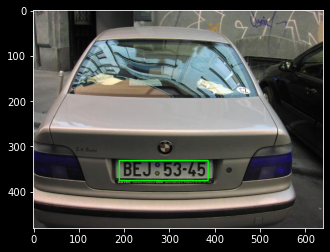

In [4]:
# Find bounding box with the highest confidence level
best_custom_vision_prediction = max(
    custom_vision_response["predictions"], key=lambda x: x["probability"]
)

# Extract the bounding box
bounding_box = best_custom_vision_prediction["boundingBox"]

# Define vertical distance from the left border
x = np.int32(bounding_box["left"] * img.shape[1])

# Define horizontal distance from the top border
y = np.int32(bounding_box["top"] * img.shape[0])

# Define rectangle width
w = np.int32(bounding_box["width"] * img.shape[1])

# Define rectangle height
h = np.int32(bounding_box["height"] * img.shape[0])

# Define top left point
point_one = (x, y)

# Define bottom right point
point_two = (x + w, y + h)

# Plot bounding box on image
img_box = cv2.rectangle(img, point_one, point_two, color=(0, 255, 0), thickness=2)

# Display image
plt.imshow(img_box)
plt.show()

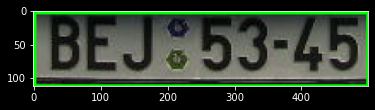

In [5]:
# Crop image
img_crop = img[point_one[1] : point_two[1], point_one[0] : point_two[0]]

# Resize image if width less than 500 pixels
if img_crop.shape[1] < 500:
    img_resize = imutils.resize(img_crop, width=500)

# Display cropped image
plt.imshow(img_resize)
plt.show()

### Perform optical character recognition

In this section the number plate in the image is converted to text using the Read API as part of the Computer Vision service.

In [6]:
# Convert cropped image to byte string
img_str = cv2.imencode(".jpg", img_resize)[1].tostring()

# Define Read API OCR endpoint
read_api_url = "{}/vision/v3.0/read/analyze".format(config.get("computer_vision", "url"))

# Call Read API to perform OCR
response = requests.post(
    url=read_api_url,
    data=img_str,
    headers={
        "Ocp-Apim-Subscription-Key": config["computer_vision"]["key"],
        "Content-Type": "application/octet-stream",
    },
)

In [7]:
# Call Read API to get result
response_final = requests.get(
    response.headers["Operation-Location"],
    headers={"Ocp-Apim-Subscription-Key": config["computer_vision"]["key"]},
)

result = response_final.json()

In [8]:
# Find text identified by the API
for line in result["analyzeResult"]["readResults"][0]["lines"]:
    print("Recognised text:", line["text"])

Recognised text: BEJ:53-45
